In [2]:
import LanusStats as ls
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import skew    
import os
import glob
fbref = ls.Fbref()
from sklearn.preprocessing import MinMaxScaler


## Data 

In [3]:
#Positions
tabla_posiciones = pd.read_csv(r"C:\Tobias\Docs\StrikerP\Tabla_2021_2024_Argentina.csv")
tabla_posiciones = tabla_posiciones.rename(columns={'Temporada': 'Season'})

#Offesnive Fbref
shooting_fbref = pd.read_csv(r"Uniones Fbref/shooting_Argentina.csv")
stats_fbref = pd.read_csv(r"c:\Tobias\Docs\StrikerP\Uniones Fbref\stats_Argentina.csv")

#Reference Index
teams_matched = pd.read_csv(r"c:\Tobias\Docs\StrikerP\teams_matched.csv")



In [4]:
#Fotmob Data Folder
folder_path = r"C:\Tobias\Docs\StrikerP\Uniones Fotmob"
pattern = os.path.join(folder_path, "*_team_Argentina.csv")

# Step 1: Read and concatenate all CSVs into a single DataFrame
csv_files = glob.glob(pattern)
df_list = []

for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df[['team_name', 'teamId', 'stat_name', 'value', 'League', 'Season']])  # Keep only needed columns

# Step 2: Concatenate all into a long-format dataframe
combined_df = pd.concat(df_list, ignore_index=True)

# Step 3: Pivot to reshape the data: each row = one team per league/season, columns = stat_names
final_df = combined_df.pivot_table(
    index=['team_name', 'teamId', 'League', 'Season'],
    columns='stat_name',
    values='value',
    aggfunc='first'  # Use first in case of duplicates
).reset_index()

# Optional: Clean up column names (stat names may be in column multi-index if any)
final_df.columns.name = None  # remove pivot column name

# Reorder columns (optional)
cols = ['team_name', 'teamId', 'League', 'Season'] + [col for col in final_df.columns if col not in ['team_name', 'teamId', 'League', 'Season']]
fotmob_data = final_df[cols]

# Check shape and preview
fotmob_data[fotmob_data["team_name"]=="Talleres"]

,team_name,teamId,League,Season,accurate_cross_team,accurate_long_balls_team,accurate_pass_team,big_chance_missed_team,big_chance_team,clean_sheet_team,...,penalty_conceded_team,penalty_won_team,poss_won_att_3rd_team,possession_percentage_team,rating_team,saves_team,total_red_card_team,total_yel_card_team,touches_in_opp_box_team,won_tackle_team
190,Talleres,10101,Argentina Copa de la Liga,2021,2.6,35.5,372.1,7.0,13.0,1.0,...,1.0,1.0,4.0,60.1,6.95,1.5,2.0,22.0,153.0,10.6
191,Talleres,10101,Argentina Copa de la Liga,2022,4.1,31.6,262.4,8.0,11.0,4.0,...,3.0,1.0,3.0,51.0,6.62,2.9,6.0,33.0,204.0,9.6
192,Talleres,10101,Argentina Copa de la Liga,2023,4.4,31.4,336.7,20.0,24.0,5.0,...,1.0,2.0,4.1,56.8,6.97,4.1,NaN,29.0,319.0,12.6
193,Talleres,10101,Argentina Copa de la Liga,2024,5.4,31.9,290.2,21.0,32.0,3.0,...,4.0,2.0,2.5,51.3,6.99,1.9,2.0,31.0,291.0,12.2
194,Talleres,10101,Argentina Primera Division,2021,5.0,34.7,324.3,32.0,55.0,10.0,...,4.0,3.0,3.4,53.8,7.00,2.8,2.0,70.0,434.0,11.5
195,Talleres,10101,Argentina Primera Division,2022,4.9,37.9,303.1,37.0,50.0,7.0,...,9.0,5.0,3.7,52.3,6.87,3.0,5.0,65.0,530.0,11.2
196,Talleres,10101,Argentina Primera Division,2023,3.7,33.2,299.6,42.0,71.0,10.0,...,3.0,3.0,3.8,49.8,7.06,3.0,3.0,59.0,570.0,10.7
197,Talleres,10101,Argentina Primera Division,2024,4.9,31.3,349.0,30.0,52.0,11.0,...,4.0,2.0,2.6,55.5,6.93,2.4,4.0,71.0,512.0,11.2


In [5]:
#Group Data
shooting_grouped = shooting_fbref.groupby(['Squad', 'Season'], as_index=False).mean(numeric_only=True)
stats_grouped = stats_fbref.groupby(['Squad', 'Season'], as_index=False).mean(numeric_only=True)
fotmob_grouped = fotmob_data.groupby(['team_name', 'Season'], as_index=False).mean(numeric_only=True)

## Index Creation

In [6]:
shooting_merged = shooting_grouped.merge(teams_matched, on='Squad', how='inner')

final_df = shooting_merged.merge(
    fotmob_grouped,
    left_on=['id', 'Season'],
    right_on=['teamId', 'Season'],
    how='inner'
)
columns_to_keep = [
    'Squad', 'id', 'Season',
    'Standard_Gls', 'Standard_Sh', 'Standard_SoT', 'Standard_SoT%',
    'Standard_Sh/90', 'Standard_SoT/90', 'Standard_G/Sh', 'Standard_G/SoT',
    'Standard_PK', 'Standard_PKatt',
    'big_chance_missed_team', 'big_chance_team', 'expected_goals_team',
    'ontarget_scoring_att_team', 'penalty_won_team', 'poss_won_att_3rd_team',
    'touches_in_opp_box_team'
]

pre_index_df = final_df[columns_to_keep]

In [7]:
# Paso 1: Definir las columnas a excluir
exclude_cols = ['Squad', 'id', 'Season']

# Paso 2: Separar columnas numéricas a normalizar
numeric_cols = [col for col in pre_index_df.columns if col not in exclude_cols]

# Paso 3: Reemplazar NaN por la media en las columnas numéricas
pre_index_df[numeric_cols] = pre_index_df[numeric_cols].apply(lambda x: x.fillna(x.mean()))

# Paso 4: Aplicar Min-Max Scaling
scaler = MinMaxScaler()
pre_index_df[numeric_cols] = scaler.fit_transform(pre_index_df[numeric_cols])
normalized_df = pre_index_df.copy()


In [8]:
weights = {
    # Goals 
    'Standard_Gls': 0.10,
    'Standard_G/Sh': 0.10,
    'Standard_G/SoT': 0.025,
    'Standard_SoT%': 0.025,
    'Standard_SoT': 0.02,
    'Standard_Sh': 0.02,
    'Standard_Sh/90': 0.01,
    'Standard_SoT/90': 0.01,
    'Standard_PK': 0.01,
    'Standard_PKatt': 0.01,
    # Generation
    'expected_goals_team': 0.25,
    'big_chance_team': 0.10,
    'ontarget_scoring_att_team': 0.10,
    'touches_in_opp_box_team': 0.1,
    'poss_won_att_3rd_team': 0.04,
    'penalty_won_team': 0.03,
    'big_chance_missed_team': 0.03,
}

# Asegurar que todas las columnas están en el DataFrame
missing = [col for col in weights if col not in normalized_df.columns]
if missing:
    raise ValueError(f"Faltan columnas necesarias: {missing}")

normalized_df['OffIndex'] = (sum(
    normalized_df[col] * weight for col, weight in weights.items()) * 100
)
offindex_mean = normalized_df['OffIndex'].mean()
# Crear la nueva columna según el valor respecto a la media
normalized_df['IsOffensive'] = normalized_df['OffIndex'].apply(
    lambda x: 'Offensive' if x > offindex_mean else 'NonOffensive')


## Descriptive Analysis

In [9]:
preview_01 = stats_grouped.merge(
    normalized_df[['Squad', 'Season', 'OffIndex', 'IsOffensive']],
    on=['Squad', 'Season'],
    how='left'
)
preview_01_grouped= preview_01.groupby(['IsOffensive'], as_index=False).mean(numeric_only=True)

preview_02 = tabla_posiciones.merge(
    normalized_df[['Squad', 'Season', 'OffIndex', 'IsOffensive']],
    on=['Squad', 'Season'],
    how='left'
)

preview_02_grouped = preview_02.groupby(['IsOffensive'], as_index=False).mean(numeric_only=True)

preview_03 = shooting_grouped.merge(
    normalized_df[['Squad', 'Season', 'OffIndex', 'IsOffensive']],
    on=['Squad', 'Season'],
    how='left')
preview_03_grouped = preview_03.groupby(['IsOffensive'], as_index=False).mean(numeric_only=True)

preview_04 = fotmob_grouped.merge(
    normalized_df[['id', 'Season', 'OffIndex', 'IsOffensive']],
    left_on=['teamId', 'Season'],
    right_on=['id', 'Season'],
    how='left'
)
preview_04_grouped = preview_04.groupby('IsOffensive', as_index=False).mean(numeric_only=True)

In [10]:
preview_01_grouped

,IsOffensive,Season,# Pl,Age,Poss,PlayingTime_MP,PlayingTime_Starts,PlayingTime_Min,PlayingTime_90s,Performance_Gls,...,Performance_PK,Performance_PKatt,Performance_CrdY,Performance_CrdR,Per90Minutes_Gls,Per90Minutes_Ast,Per90Minutes_G+A,Per90Minutes_G-PK,Per90Minutes_G+A-PK,OffIndex
0,NonOffensive,2022.3,29.866667,26.789167,47.741667,20.05,220.55,1806.25,20.068333,19.008333,...,1.85,2.35,49.3,3.066667,0.954083,0.650667,1.606083,0.865917,1.51675,30.138208
1,Offensive,2022.8,29.250000,27.053000,52.656000,20.54,225.94,1850.70,20.561000,25.350000,...,2.44,3.13,50.0,2.660000,1.246800,0.844100,2.090900,1.126500,1.97040,50.006530


In [11]:
preview_02_grouped

,IsOffensive,pos,Pts,PJ,PG,PE,PP,GF,GC,Diff,Season,OffIndex
0,NonOffensive,17.683333,48.916667,39.90,12.20,12.316667,15.383333,39.05,45.866667,-6.816667,2022.3,30.138208
1,Offensive,10.160000,60.440000,40.76,15.86,12.860000,12.040000,51.58,43.420000,8.160000,2022.8,50.006530


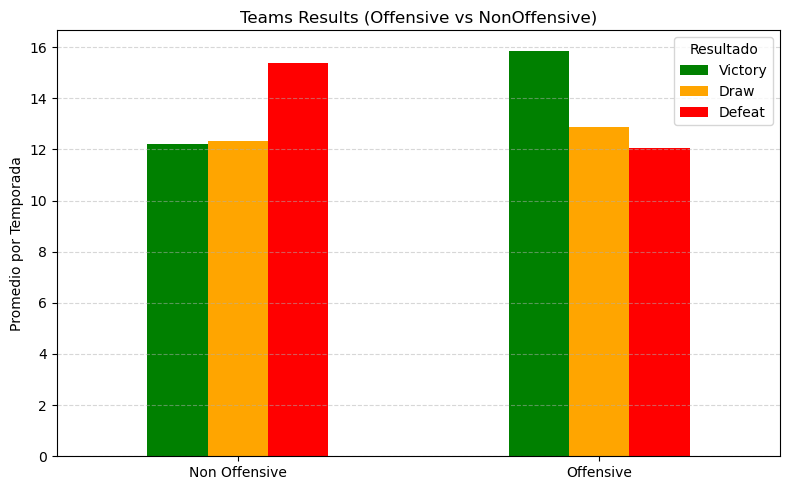

In [18]:
agg_result = preview_02_grouped.groupby('IsOffensive')[['PG', 'PE', 'PP']].mean()
agg_result.index = ['Non Offensive', 'Offensive']
agg_result = agg_result.rename(columns={'PG': 'Victory', 'PE': 'Draw', 'PP': 'Defeat'})

# Graficamos barras agrupadas
ax = agg_result.plot(kind='bar', figsize=(8, 5), color=['green', 'orange', 'red'])
plt.title('Teams Results (Offensive vs NonOffensive)')
plt.ylabel('Promedio por Temporada')
plt.xticks(rotation=0)
plt.legend(title='Resultado')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [13]:
preview_03

,Squad,Season,# Pl,90s,Standard_Gls,Standard_Sh,Standard_SoT,Standard_SoT%,Standard_Sh/90,Standard_SoT/90,Standard_G/Sh,Standard_G/SoT,Standard_Dist,Standard_PK,Standard_PKatt,OffIndex,IsOffensive
0,Aldosivi,2021,28.5,19.00,21.0,174.0,59.5,35.40,9.045,3.190,0.110,0.320,NaN,2.0,2.5,25.222650,NonOffensive
1,Aldosivi,2022,33.0,21.00,16.5,198.0,51.5,27.50,9.170,2.485,0.080,0.290,NaN,2.5,2.5,25.884982,NonOffensive
2,Arg Juniors,2021,30.5,19.00,19.5,244.0,71.5,30.40,12.585,3.800,0.075,0.250,NaN,1.5,3.0,26.897051,NonOffensive
3,Arg Juniors,2022,25.0,21.65,27.0,288.5,88.0,30.75,13.420,4.130,0.085,0.280,NaN,2.5,2.5,50.152337,Offensive
4,Arg Juniors,2023,26.5,20.50,24.5,271.0,84.0,31.55,12.805,4.025,0.090,0.270,NaN,3.5,4.0,60.847228,Offensive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Unión,2024,25.5,20.50,21.0,258.5,74.0,28.30,12.415,3.510,0.080,0.275,NaN,2.0,2.0,40.474053,Offensive
106,Vélez Sarsfield,2021,28.0,19.50,28.0,233.0,86.5,37.65,12.055,4.545,0.120,0.315,NaN,1.0,2.0,39.290009,Offensive
107,Vélez Sarsfield,2022,30.0,20.50,21.0,257.0,85.0,33.15,12.700,4.215,0.065,0.200,NaN,3.5,4.0,40.581755,Offensive
108,Vélez Sarsfield,2023,27.0,20.50,19.5,201.5,65.5,33.60,9.785,3.285,0.100,0.290,NaN,1.0,1.0,34.363461,NonOffensive


In [14]:
preview_04.T

,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
team_name,Aldosivi,Aldosivi,Argentinos Juniors,Argentinos Juniors,Argentinos Juniors,Argentinos Juniors,Arsenal Sarandi,Arsenal Sarandi,Arsenal Sarandi,Atletico Tucuman,...,Tigre,Tigre,Union,Union,Union,Union,Velez Sarsfield,Velez Sarsfield,Velez Sarsfield,Velez Sarsfield
Season,2021,2022,2021,2022,2023,2024,2021,2022,2023,2021,...,2023,2024,2021,2022,2023,2024,2021,2022,2023,2024
teamId,161728.0,161728.0,10086.0,10086.0,10086.0,10086.0,10098.0,10098.0,10098.0,161727.0,...,89396.0,89396.0,10096.0,10096.0,10096.0,10096.0,10079.0,10079.0,10079.0,10079.0
accurate_cross_team,3.65,3.05,4.85,5.15,6.2,4.95,4.25,5.2,4.7,6.0,...,5.8,3.65,4.25,5.35,4.85,5.85,4.6,5.15,4.25,4.55
accurate_long_balls_team,29.1,29.35,36.55,34.0,32.55,31.15,29.25,25.8,24.35,31.05,...,26.35,24.9,29.4,23.6,21.5,29.05,31.0,27.45,24.6,25.3
accurate_pass_team,363.45,251.8,398.45,347.3,382.95,327.6,226.8,215.6,245.7,286.9,...,329.3,320.95,266.05,236.6,246.75,259.45,409.75,346.6,273.7,304.4
big_chance_missed_team,12.5,9.0,16.0,29.5,25.5,19.5,13.5,21.5,14.5,16.0,...,23.5,18.5,11.5,22.5,17.5,24.5,19.0,22.0,17.0,32.0
big_chance_team,24.5,20.5,26.5,45.0,41.0,34.5,18.0,35.0,23.0,24.5,...,35.0,28.0,22.0,35.0,25.5,34.0,32.5,35.0,26.0,51.0
clean_sheet_team,4.5,4.5,6.5,7.0,8.0,8.0,5.5,5.0,5.0,4.0,...,6.5,5.5,5.5,6.0,9.5,9.0,7.5,4.5,6.5,11.5
corner_taken_team,64.0,79.0,85.5,103.0,116.0,124.5,70.0,97.5,89.0,75.5,...,102.0,72.5,79.5,125.0,108.0,91.5,82.5,98.0,88.0,113.0


In [15]:
shooting_table = shooting_grouped.merge(tabla_posiciones, on='Squad', how='inner')
preview_04.columns

Index(['team_name', 'Season', 'teamId', 'accurate_cross_team',
       'accurate_long_balls_team', 'accurate_pass_team',
       'big_chance_missed_team', 'big_chance_team', 'clean_sheet_team',
       'corner_taken_team', 'effective_clearance_team',
       'expected_goals_conceded_team', 'expected_goals_team',
       'fk_foul_lost_team', 'interception_team', 'ontarget_scoring_att_team',
       'penalty_conceded_team', 'penalty_won_team', 'poss_won_att_3rd_team',
       'possession_percentage_team', 'rating_team', 'saves_team',
       'total_red_card_team', 'total_yel_card_team', 'touches_in_opp_box_team',
       'won_tackle_team', 'id', 'OffIndex', 'IsOffensive'],
      dtype='object')

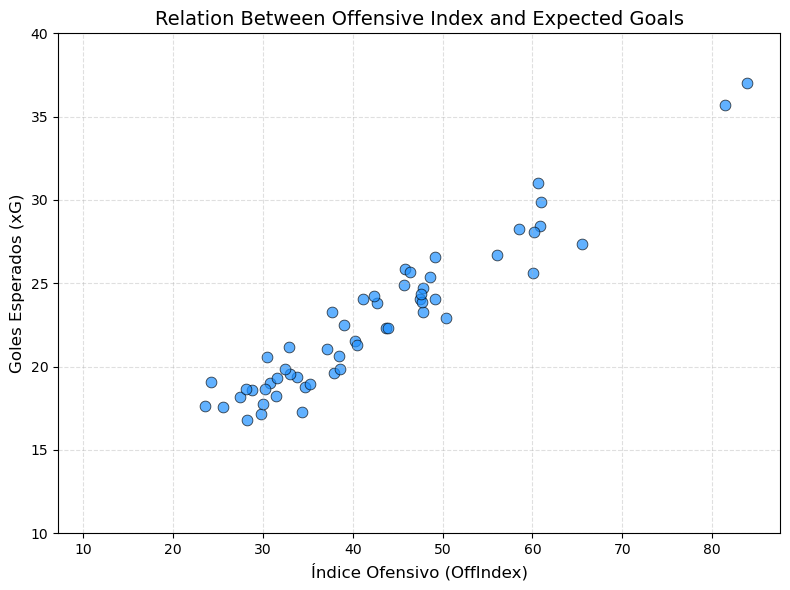

In [16]:
preview_04
plt.figure(figsize=(8, 6))
sb.scatterplot(data=preview_04, x="OffIndex", y="expected_goals_team", color="dodgerblue", s=60, edgecolor='black', alpha=0.7)

plt.title("Relation Between Offensive Index and Expected Goals", fontsize=14)
plt.xlabel("Índice Ofensivo (OffIndex)", fontsize=12)
plt.ylabel("Goles Esperados (xG)", fontsize=12)
plt.ylim(10, 40)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

<Axes: xlabel='OffIndex', ylabel='expected_goals_conceded_team'>

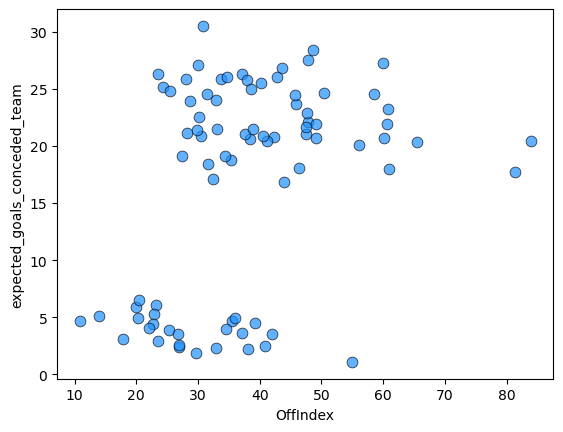

In [17]:
sb.scatterplot(data=preview_04, x="OffIndex", y="expected_goals_conceded_team", color="dodgerblue", s=60, edgecolor='black', alpha=0.7)
